<a href="https://colab.research.google.com/github/confusedolive/Jeronimo-CE888/blob/main/lab03/Unfinished1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score, StratifiedKFold 


 preprocessing 

In [8]:
df = pd.read_csv('https://raw.githubusercontent.com/albanda/CE888/master/lab3/bank-additional-full.csv', sep = ';')
output = 'y'

df_1 = df.copy()
df_1 = df_1.dropna()
del df_1['duration']

categorical = df_1.columns[(df_1.dtypes == object) & (df_1.columns != output)]
features = df_1.columns[df_1.columns != output]

le = LabelEncoder()
df_1[[output]] = df_1[[output]].apply(le.fit_transform)

X_df = df_1[features].copy()
y_df = df_1[[output]].copy()
df_dummies = pd.get_dummies(X_df, columns = categorical )

plotting label inbalance

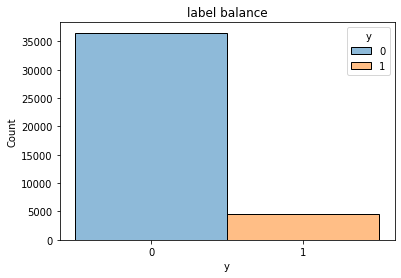

In [9]:

sns.histplot(df_1, x = 'y',discrete=True, shrink = 1,  hue='y')
plt.title('label balance')
plt.xticks([0,1])
plt.show()

In [24]:
x = df_dummies.values
y = y_df.values

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=50, stratify=y)
#checking label is stratified
unique_real, counts_real = np.unique(y, return_counts=True)
unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_test, counts_test = np.unique(y_test, return_counts=True)
balance_train = dict(zip(unique_train,counts_train))
balance_test = dict(zip(unique_test, counts_test))
balance_real = dict(zip(unique_real, counts_real))

print(f'Dataset label inbalance: {balance_real[0]/ len(y):.2f}')
print(f'label ratio in real dataframe no : yes = {balance_real[0]/balance_real[1]:.2f}: 1')
print(f'label ratio in train data no : yes = {balance_train[0]/balance_train[1]:.2f}: 1')
print(f'label ratio in test data no : yes = {balance_test[0]/ balance_test[1]:.2f}: 1')

Dataset label inbalance: 0.89
label ratio in real dataframe no : yes = 7.88: 1
label ratio in train data no : yes = 7.88: 1
label ratio in test data no : yes = 7.88: 1


Random Forest classifier depth=3 n_estimators=100 on train set with 10fold cv

In [20]:
clf = RandomForestClassifier(max_depth=3, n_estimators=100)
dmf = DummyClassifier(strategy='stratified')
scores = cross_val_score(clf, X_train, y_train.ravel(), cv=10, scoring=metrics.make_scorer(metrics.f1_score))
dmf_scores = cross_val_score(dmf, X_train, y_train.ravel(), cv=10, scoring=metrics.make_scorer(metrics.f1_score))

print(f'F1_scores mean: {np.mean(scores):.2f} +/- {np.std(scores):.2f}')
print(f'dummy F1_scores mean: {np.mean(dmf_scores):.2f} +/- {np.std(dmf_scores):.2f}')

F1_scores mean: 0.25 +/- 0.04
dummy F1_scores mean: 0.12 +/- 0.01


Using gridsearch to find best parameters for random forest classifier

In [21]:
params = {'max_depth':[3,6,8], 'n_estimators':list(range(100,501,100))}
grid_s = GridSearchCV(clf, param_grid=params, scoring=metrics.make_scorer(metrics.f1_score))
grid_s.fit(X_train, y_train.ravel())
print(grid_s.best_params_)

{'max_depth': 8, 'n_estimators': 400}


In [25]:
clf = RandomForestClassifier(max_depth=8, n_estimators=400)
dmf = DummyClassifier(strategy='stratified')
scores = cross_val_score(clf, X_train, y_train.ravel(), cv=10, scoring=metrics.make_scorer(metrics.f1_score))
dmf_scores = cross_val_score(dmf, X_train, y_train.ravel(), cv=10, scoring=metrics.make_scorer(metrics.f1_score))

print(f'F1_scores mean: {np.mean(scores):.2f} +/- {np.std(scores):.2f}')
print(f'dummy F1_scores mean: {np.mean(dmf_scores):.2f} +/- {np.std(dmf_scores):.2f}')

F1_scores mean: 0.30 +/- 0.04
dummy F1_scores mean: 0.11 +/- 0.01


Finding top 3 features

In [31]:
clf.fit(X_train, y_train.ravel())
importances = clf.feature_importances_

std = np.std([tree.feature_importances_ for tree in clf.estimators_],
            axis=0)
indices = np.argsort(importances)[::-1]
print('Top 3 features:')
for f in range(3):
    print(f'{f + 1}:  {df_dummies.columns[indices[f]]} ({importances[indices[f]]:.2f})')


Top 3 features:
1:  nr.employed (0.17)
2:  euribor3m (0.16)
3:  pdays (0.11)


In [36]:
clf = RandomForestClassifier(max_depth=8, n_estimators=400)
clf.fit(X_test, y_test.ravel())
y_pred = clf.predict(X_test)
F1_score = metrics.f1_score(y_test.ravel(), y_pred) 
print(f'F1 : {F1_score:.2f}')   

F1 : 0.49
